In [1]:
from scipy.io import  loadmat
import numpy as np
from matplotlib import pyplot as plt
import scipy.signal as sn
from mne.viz import plot_topomap
import mne
import scipy.linalg as la
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as lda
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import SVC
from sklearn.feature_selection import mutual_info_classif

from pathlib import Path
from tqdm import tqdm

from sklearn.metrics import roc_auc_score, roc_curve

In [44]:
char_box = np.array(list('ABCDEFGHIJKLMNOPQRSTUVWXYZ123456789_')).reshape((6, 6)).T
char_box

array([['A', 'G', 'M', 'S', 'Y', '5'],
       ['B', 'H', 'N', 'T', 'Z', '6'],
       ['C', 'I', 'O', 'U', '1', '7'],
       ['D', 'J', 'P', 'V', '2', '8'],
       ['E', 'K', 'Q', 'W', '3', '9'],
       ['F', 'L', 'R', 'X', '4', '_']], dtype='<U1')

In [3]:
struct = loadmat('DZ2/2/Subject_A_Train.mat')
print('\n'.join([f'{k}: {v.shape if isinstance(v, np.ndarray) else v}' for k, v in struct.items()]))

__header__: b'MATLAB 5.0 MAT-file, Platform: PCWIN, Created on: Mon Nov 29 08:14:54 2004'
__version__: 1.0
__globals__: []
Signal: (85, 7794, 64)
TargetChar: (1,)
Flashing: (85, 7794)
StimulusCode: (85, 7794)
StimulusType: (85, 7794)


In [4]:
fs = 240
Nstims = 12
frame = np.arange(0, fs)
# fs, Nstims, frame.shape

In [5]:
data = struct['Signal']
Nepochs, nT, Nchannels = data.shape

In [6]:
stim_code = struct['StimulusCode']

In [7]:
stim_type = struct['StimulusType']

In [8]:
target_list = struct['TargetChar'][0]
target_list

'EAEVQTDOJG8RBRGONCEDHCTUIDBPUHMEM6OUXOCFOUKWA4VJEFRZROLHYNQDW_EKTLBWXEPOUIKZERYOOTHQI'

In [9]:
stim_roll = np.roll(stim_code,1,axis = 1)
idc = np.argwhere(np.diff(stim_roll))
first_idc = idc[np.arange(0,idc.shape[0],2),1]
first_idc = first_idc.reshape(stim_code.shape[0],\
                            int(round(first_idc.shape[0]/stim_code.shape[0])))
assert np.unique(first_idc).shape == first_idc[0, :].shape
first_idc = np.unique(first_idc).astype(int)

In [10]:
#количество повторений всех стимулов (12 штук) в эпохе
Ncycles = int(round(first_idc.shape[0]) / Nstims)
Ncycles

15

In [11]:
#соответствующий массив, хранящий  информацию о номере стимула для каждой эпохи
stims = stim_code[:,first_idc].astype('int')
stims.shape

(85, 180)

In [12]:
#список всех стимулов (1...12)
stims12 = stims[0,:Nstims]
stims12 = np.sort(stims12)
stims12

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12])

In [13]:
#функция для усреднения ВСЕХ целевых (с p300) и нецелевых стимулов и их построения на одном графике
def plot_average(data,frame,Nchannels,char_box,target_list,Nepochs,ch_to_plot,fs):
    t = frame/fs
    
    target_trials= np.zeros((frame.shape[0],Nchannels))
    non_target_trials= np.zeros((frame.shape[0],Nchannels))
    
    
    for i in range(Nepochs):  
        #для каждой эпохи декодируем стимулы, соответствующие символу ("координаты, 1-6, 7-12")
        target_stims = np.argwhere(char_box==target_list[i])[0]+1
        target_stims[1] += int(round(Nstims/2))
        #все осальные стимулы относим к нецелевым
        non_target_stims = np.setdiff1d(stims12,target_stims)
        
        #временные индексы в одной эпохе, 
        #соответствующие нецелевым и целевым стимулам (каждый стимул повторялся 15 раз)
        non_target_idc = first_idc[np.isin(stims[i,:],non_target_stims)][:,np.newaxis]
        target_idc = first_idc[np.isin(stims[i,:],target_stims)][:,np.newaxis]
        
        #вырезаем соответствующие временные ряды и усредняем по повторением в эпохе
        target_trials += np.mean(data[i,target_idc+frame[np.newaxis,:],:],axis = 0)
        non_target_trials += np.mean(data[i,non_target_idc+frame[np.newaxis,:],:],axis = 0)
        
    #усредняем по эпохам
    target_trials = target_trials/Nepochs
    non_target_trials /= Nepochs
    
    #стром усредненные сигналы в каком-нибудь канале
    plt.figure()
    plt.plot(t*1000,target_trials[:,ch_to_plot])
    plt.plot(t*1000,non_target_trials[:,ch_to_plot])
    plt.xlabel('time, ms')
    plt.ylabel('Amplitude, uV')
    
    plt.show()
    
    return target_trials

In [14]:
#координаты каналов, сразу преобразуем их к виду xyz
chan_locs= np.loadtxt('DZ2/2/eloc64.txt',usecols = (1,2))
chan_locs[:,0]  = chan_locs[:,0]*np.pi/180
ch_pos = np.ndarray(chan_locs.shape)
ch_pos[:,0]= np.sin(chan_locs[:,1])*np.sin(chan_locs[:,0]) #x
ch_pos[:,1]= np.sin(chan_locs[:,1])*np.cos(chan_locs[:,0]) #y
z_pos = np.cos(chan_locs[:,1])[:,np.newaxis]

#имена каналов
chan_names= np.loadtxt('DZ2/2/eloc64.txt',usecols = 3,dtype ='str').tolist()
chan_locs.shape, ' '.join(chan_names)

((64, 2),
 'Fc5. Fc3. Fc1. Fcz. Fc2. Fc4. Fc6. C5.. C3.. C1.. Cz.. C2.. C4.. C6.. Cp5. Cp3. Cp1. Cpz. Cp2. Cp4. Cp6. Fp1. Fpz. Fp2. Af7. Af3. Afz. Af4. Af8. F7.. F5.. F3.. F1.. Fz.. F2.. F4.. F6.. F8.. Ft7. Ft8. T7.. T8.. T9.. T10. Tp7. Tp8. P7.. P5.. P3.. P1.. Pz.. P2.. P4.. P6.. P8.. Po7. Po3. Poz. Po4. Po8. O1.. Oz.. O2.. Iz..')

In [15]:
def filter_data(data):
    b,a = sn.butter(4,(0.5,20),btype = 'bandpass',fs = fs)
    return sn.filtfilt(b,a,data,axis  = 1)

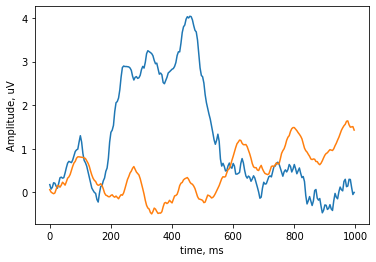

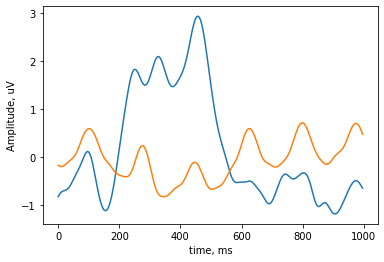

In [16]:
target_trials = plot_average(data, frame, Nchannels,
                             char_box, target_list, Nepochs, 10, fs)
target_trials = plot_average(filter_data(data), frame, Nchannels,
                             char_box, target_list, Nepochs, 10, fs)

In [17]:
# %matplotlib inline
def save_p300_topomap(trials, fs, output_folder=None):
    #Cтроим динамику топографии
    time = np.arange(0,1,1/fs)
    output_path = Path('output')
    if output_folder:
        output_path = output_path / output_folder
    output_path.mkdir(exist_ok=True, parents=True)
    for nt in (np.arange(0.15,0.6,0.01)*fs).astype(int):
        plt.close('all')
        plot_topomap(trials[nt,:],pos = ch_pos,names = chan_names,show_names = True)
        plt.title(str(time[nt]*1000)+'ms')
        plt.savefig(output_path / f'{nt}.png')
# save_p300_topomap(target_trials, 'filtered')

In [18]:
#здаем монтаж, информацию о каналах 
full_coord= np.concatenate((ch_pos,z_pos),axis = 1)
dict_coord = dict()
for i in range(Nchannels):
    dict_coord[chan_names[i]] = full_coord[i,:]
DIG = mne.channels.make_dig_montage(ch_pos=dict_coord)

#создаем информацию о записи и задаем её монтаж
info = mne.create_info(chan_names,ch_types = 'eeg', sfreq=fs)
info.set_montage(DIG)

/tmp/ipykernel_331247/3230893989.py:10: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  info.set_montage(DIG)


<Info | 8 non-empty values
 bads: []
 ch_names: Fc5., Fc3., Fc1., Fcz., Fc2., Fc4., Fc6., C5.., C3.., C1.., ...
 chs: 64 EEG
 custom_ref_applied: False
 dig: 64 items (64 EEG)
 highpass: 0.0 Hz
 lowpass: 120.0 Hz
 meas_date: unspecified
 nchan: 64
 projs: []
 sfreq: 240.0 Hz
>

In [19]:
#создаем структуру epochs mne
epochs = mne.EpochsArray(data.transpose(0,2,1), info)

Not setting metadata
Not setting metadata
85 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped


In [20]:
#фильтруем перед ICA, причем не в том диапазоне, в котором мы дальше работаем, поэтому создаем до этого
#копию массива, которая остается незимененной. 
epochs_copy = epochs.copy()
_ = epochs.filter(62,58,method='iir')
_ = epochs.filter(2, 40,  method='iir')

Setting up band-stop filter from 58 - 62 Hz

IIR filter parameters
---------------------
Butterworth bandstop zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 58.00, 62.00 Hz: -6.02, -6.02 dB

Setting up band-pass filter from 2 - 40 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 2.00, 40.00 Hz: -6.02, -6.02 dB



Using matplotlib as 2D backend.


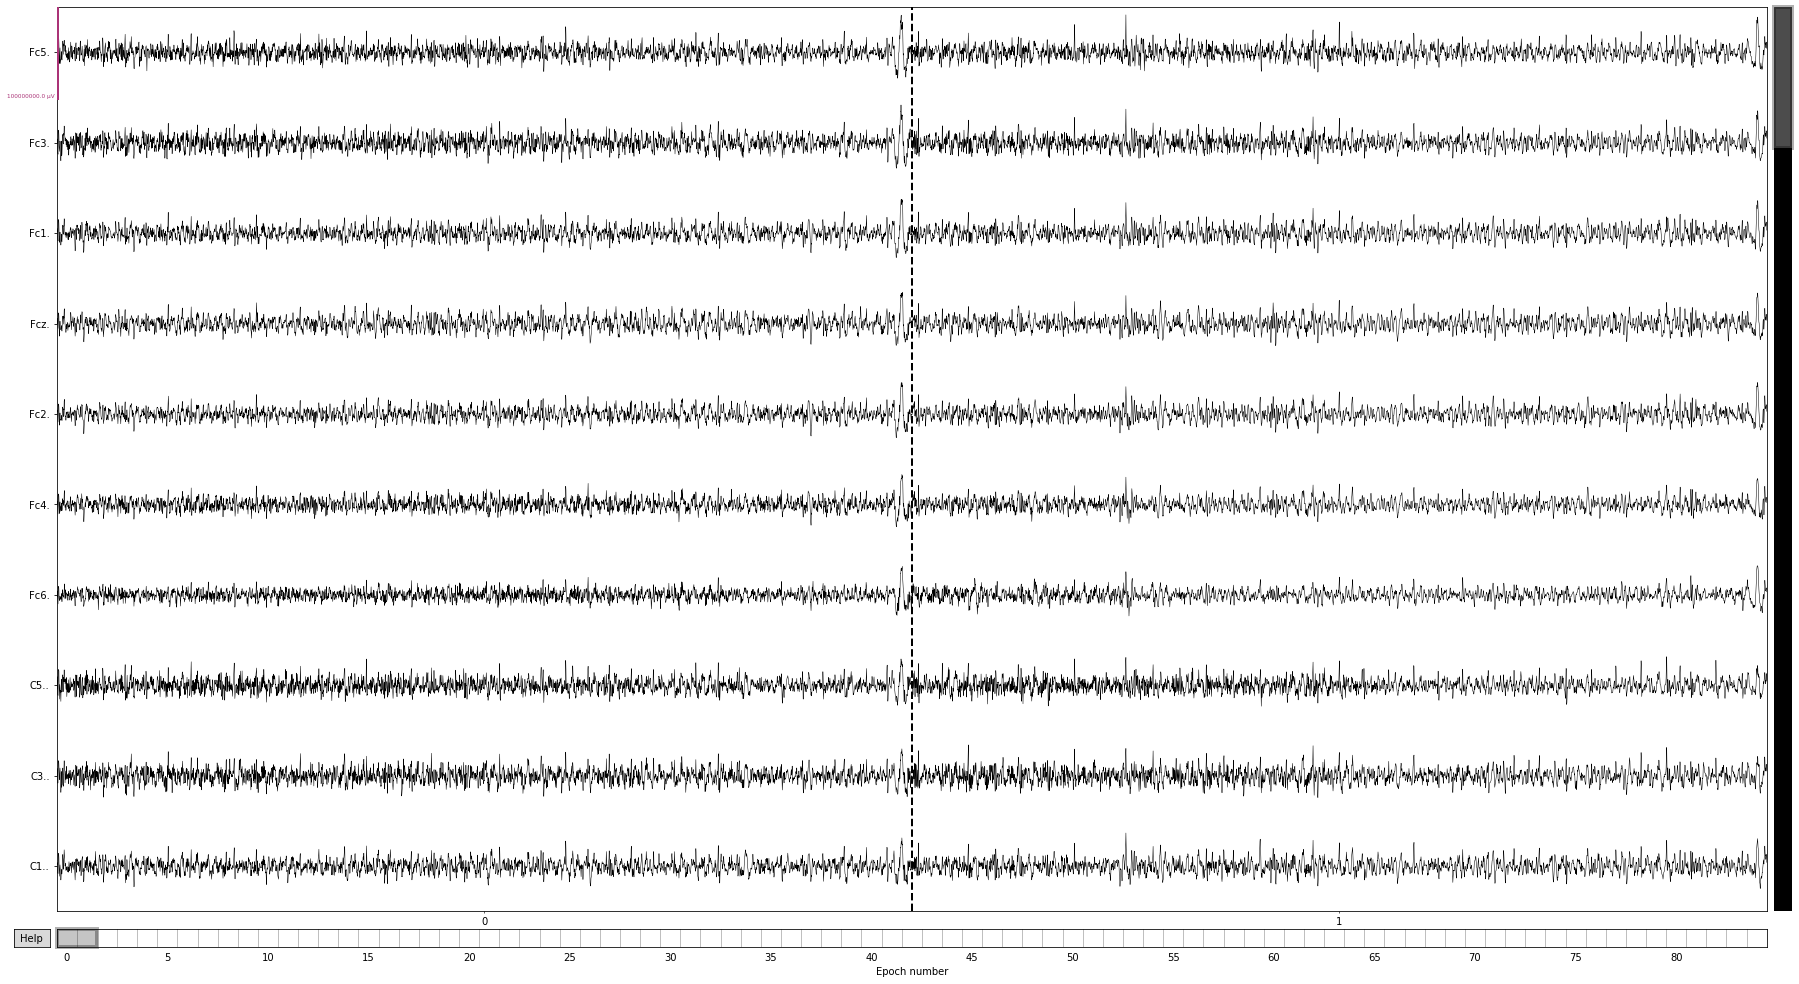

Dropped 4 epochs: 10, 29, 61, 62


Number of events,81
Events,1: 81
Time range,0.000 – 32.471 sec
Baseline,off


In [21]:
# %matplotlib qt
#выводим сигнал перед ICA для нахождения плохих эпох, затем записываем из в список и удаляем
epochs.plot(n_epochs = 2, n_channels=10, scalings=dict(eeg=50))

bad_epochs=(10, 29, 61, 62)
epochs.drop(bad_epochs)

Reading ica-ica.fif ...
Now restoring ICA solution ...
Ready.


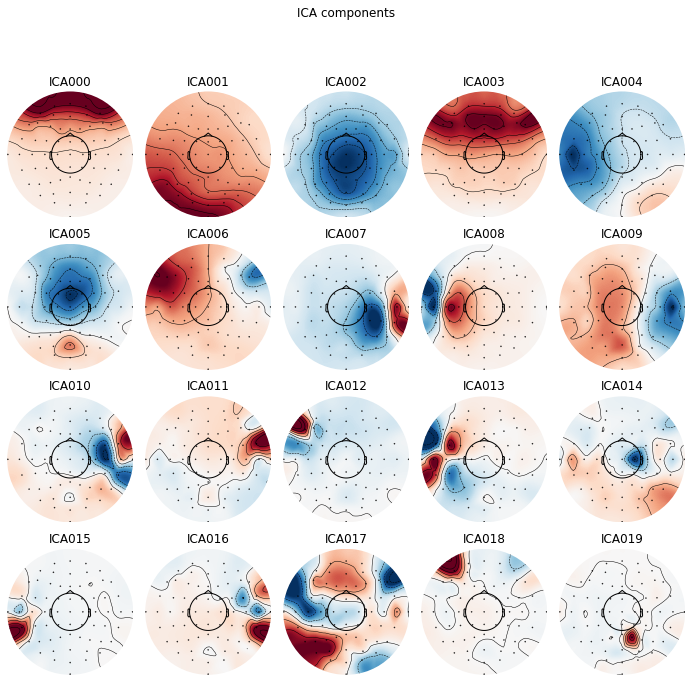

Not setting metadata
Not setting metadata
81 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped


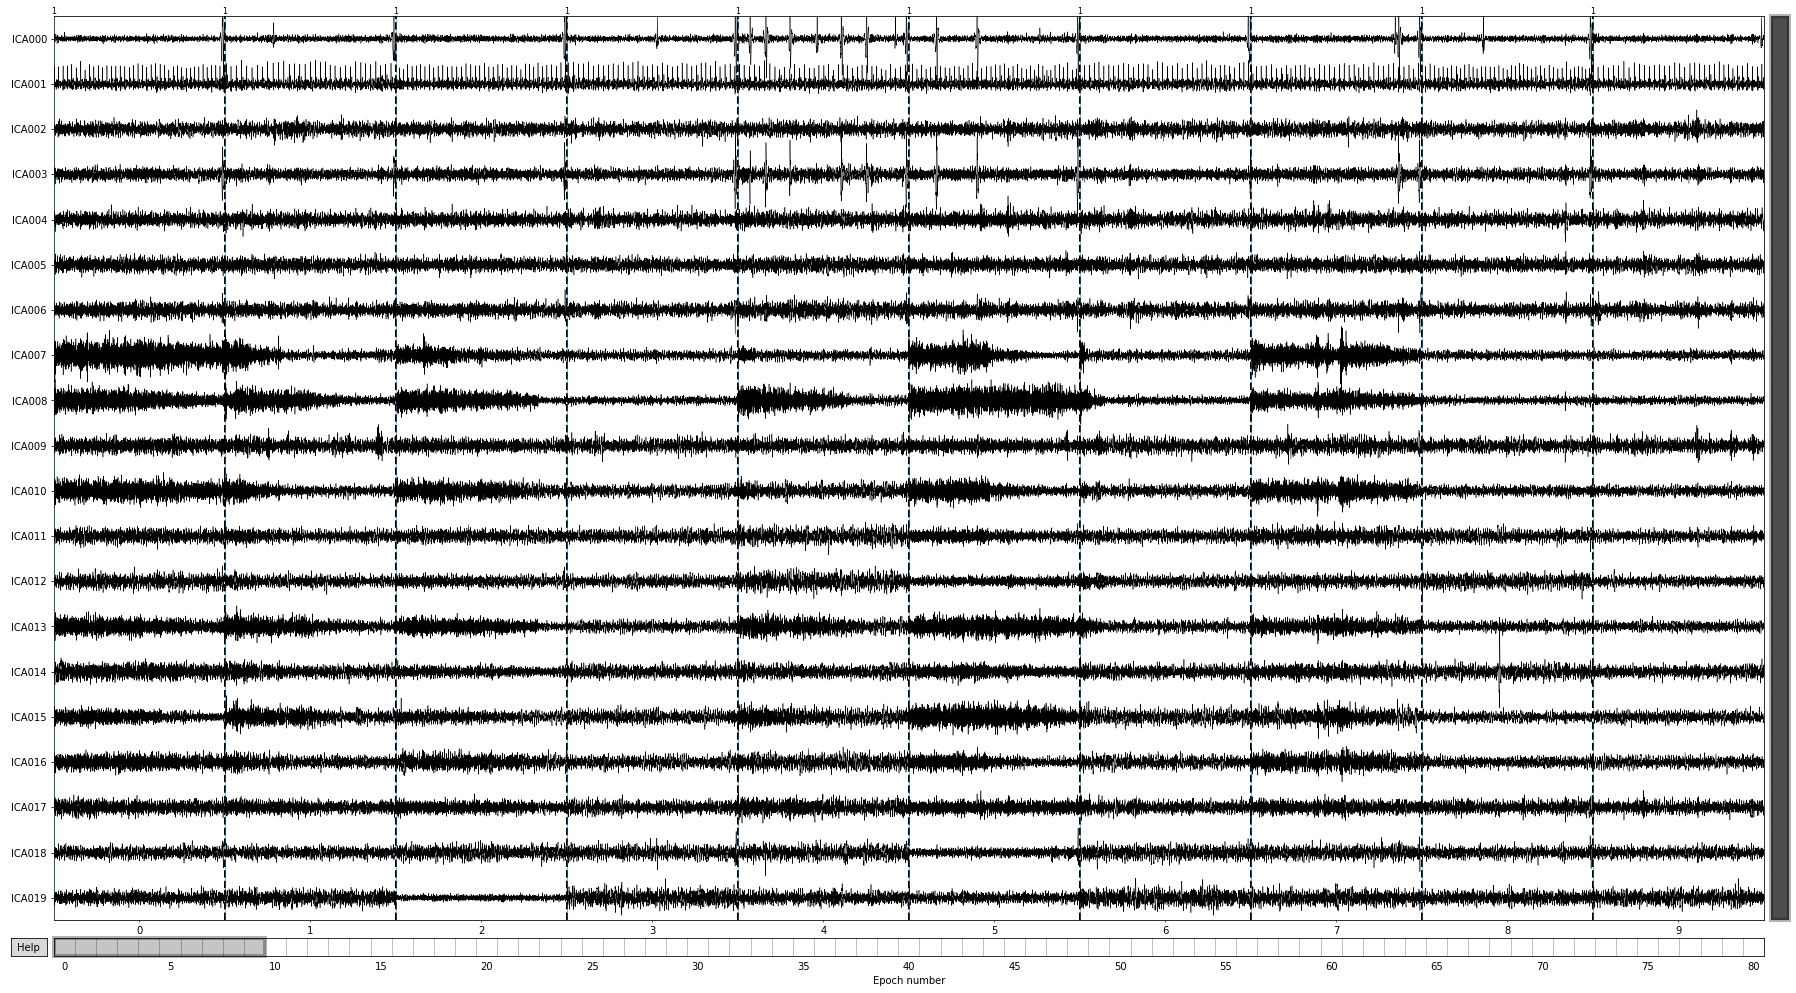

In [22]:
if Path('ica-ica.fif').exists():
    ica = mne.preprocessing.read_ica('ica-ica.fif')
else:
    # делаем ICA (один раз, затем созраняем и комментируем это)
    n_components = 20
    ica = mne.preprocessing.ICA(n_components=n_components,
                                random_state = 0, 
                                method='infomax',
                                fit_params=dict(extended=True))

    ica.fit(epochs)

    ica.save('ica-ica.fif')

# строим тогографии и временные ряды
ica.plot_components()
ica.plot_sources(epochs,start = 0,stop = 10)

del epochs

In [23]:
bad_components = (0,1,3,7,8,13)
clean_epochs = ica.apply(epochs_copy,exclude = bad_components)

# снова переходим от структуры mne к массиву
data= clean_epochs.get_data().transpose(0,2,1)
del clean_epochs

Applying ICA to Epochs instance
    Transforming to ICA space (20 components)
    Zeroing out 6 ICA components
    Projecting back using 64 PCA components


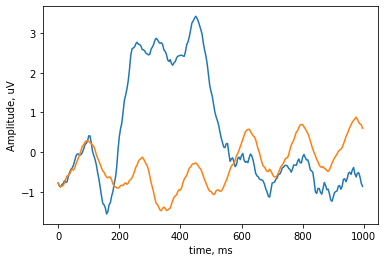

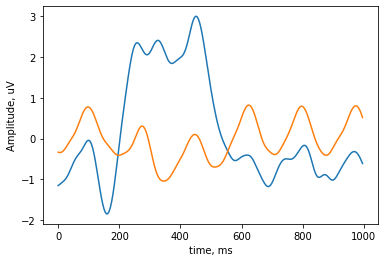

In [24]:
#строим усредненные графики и убеждаемся, что не удалили полезный сигнал
target_averaged = plot_average(data,frame,Nchannels,char_box,target_list,Nepochs,10,fs)
data = filter_data(data)
_ = plot_average(data,frame,Nchannels,char_box,target_list,Nepochs,10,fs)

In [25]:
#удаляем плохие эпохи из всех структур
data = data[np.setdiff1d(np.arange(Nepochs),bad_epochs),:,:]
stims = stims[np.setdiff1d(np.arange(Nepochs),bad_epochs),:]
Nepochs = Nepochs - len(bad_epochs)
minus = 0 
for i in range(len(bad_epochs)):
    target_list = target_list[:bad_epochs[i]+minus] + target_list[bad_epochs[i]+minus+1:]
    minus -= 1

In [26]:
Nepochs

81

In [27]:
def pca(src, n_components=5):
    # делаем аналих главных компонент для усрдененного сигнала P300. 
    # таким образом, фильтры pca будут автоматически
    # выделять те каналы, в которых присутствие p300 наибольшее
    cov = np.cov(src.T)
    lam,w = la.eig(cov)
    #сортируем собтсвенные векторы
    w = np.real(w[:,np.argsort(np.abs(lam))[::-1]])
    w = w[:,:n_components]
    return w

In [28]:
w = pca(target_averaged)
# apply spatial filter
pca_filtered = data @ w

In [29]:
target_averaged.shape, data.shape, pca_filtered.shape

((240, 64), (81, 7794, 64), (81, 7794, 5))

In [30]:
from pdb import set_trace

In [31]:
def trca(src, first_idc, frame):
    
    num_epochs, num_samples, num_channels = src.shape
    
    S = np.zeros((num_channels, num_channels))
    Q = np.zeros((num_channels, num_channels))
        
    target_stims = np.argwhere(char_box == target_list[i])[0] + 1
    target_stims[1] += int(round(Nstims / 2))
    non_target_stims = np.setdiff1d(stims12, target_stims)
    non_target_idc = first_idc[np.isin(stims[i, :], non_target_stims)][:, np.newaxis]
    target_idc = first_idc[np.isin(stims[i, :], target_stims)][:, np.newaxis]
    
    for epoch in tqdm(src[::2]):
#         set_trace()
        for k in target_idc:
            xk = epoch[k + frame[np.newaxis, :], :][0]
#             xk -= np.mean(xk, axis=0)
            Q += np.cov(xk.T)
            for l in target_idc:
                if k != l:
                    xl = epoch[l + frame[np.newaxis, :], :][0]
#                     xl -= np.mean(xl, axis=0)
                    tmp = xk.T @ xl / xk.shape[0]
                    S += tmp
    
#     return S / (len(target_idc)), Q / len(target_idc)
    return S, Q

a. Сформируйте ковариационные матрицы числителя и знаменателя (соотношения Рэлея), используя только эпохи, на которых ожидается появление потенциала P300

In [32]:
S, Q = trca(np.pad(data, ((0, 0), (0, len(frame)), (0, 0)), 'constant', constant_values=0),
            first_idc, frame[:])
S.shape, Q.shape

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 41/41 [00:10<00:00,  4.08it/s]


((64, 64), (64, 64))

b. Визуализируйте спектр обобщённых собственных чисел

array([ 3.10210088+0.j,  1.75960064+0.j,  1.29237505+0.j,  1.19700244+0.j,
        1.04488949+0.j, -1.35563068+0.j,  0.96861659+0.j,  0.84553709+0.j,
       -0.98512441+0.j,  0.7348121 +0.j,  0.67876855+0.j,  0.65141214+0.j,
        0.58937623+0.j,  0.57159313+0.j,  0.52019841+0.j,  0.46499575+0.j,
        0.4286396 +0.j,  0.39778919+0.j,  0.31183666+0.j,  0.2689691 +0.j,
       -0.7505423 +0.j,  0.22072446+0.j,  0.19471174+0.j, -0.71388021+0.j,
        0.16194983+0.j,  0.14400649+0.j,  0.1171998 +0.j, -0.69381404+0.j,
        0.08908934+0.j,  0.0395441 +0.j, -0.64564704+0.j, -0.00358417+0.j,
       -0.01486483+0.j, -0.62734618+0.j, -0.04314383+0.j, -0.05625383+0.j,
       -0.09126839+0.j, -0.10313375+0.j, -0.11151566+0.j, -0.14317524+0.j,
       -0.60144884+0.j, -0.18884444+0.j, -0.20264722+0.j, -0.2237359 +0.j,
       -0.24907221+0.j, -0.26057717+0.j, -0.57098101+0.j, -0.56376822+0.j,
       -0.55134652+0.j, -0.5385847 +0.j, -0.29380408+0.j, -0.52059947+0.j,
       -0.50900959+0.j, -

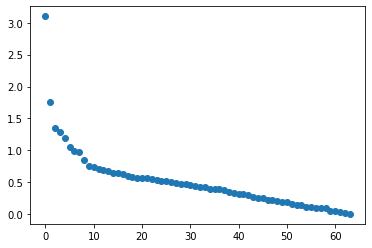

In [33]:
lam, w = la.eig(la.sqrtm(la.inv(Q)) @ S @ la.sqrtm(la.inv(Q)))
# lam, w = la.eig(la.inv(Q) @ S)
lam.shape, w.shape

# fig, axs = plt.subplots(1, 2, figsize=(12, 8))
plt.scatter(range(len(lam[:])), np.sort(np.abs(lam))[::-1][:])
# axs[1].scatter(range(len(lam[1:])), np.sort(np.abs(lam))[::-1][1:])

# lam = np.sort(np.abs(lam))[::-1]
# w = np.real(w[:,np.argsort(np.abs(lam))[::-1]])
w = np.real(la.sqrtm(la.inv(Q)) @ np.real(w[:, np.argsort(np.abs(lam))[::-1]]))
w.shape
lam

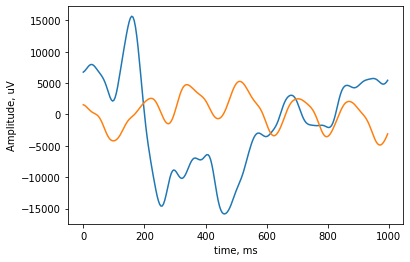

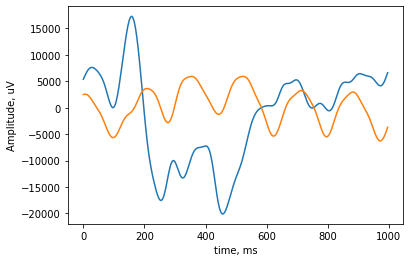

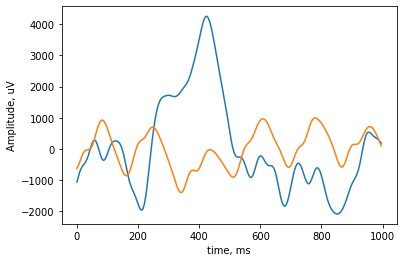

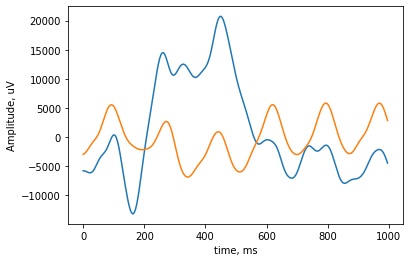

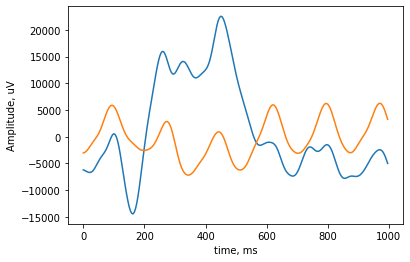

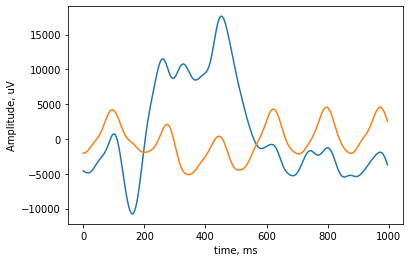

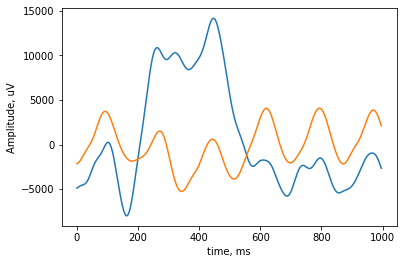

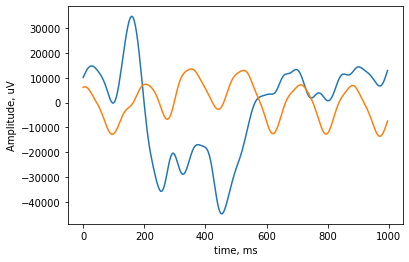

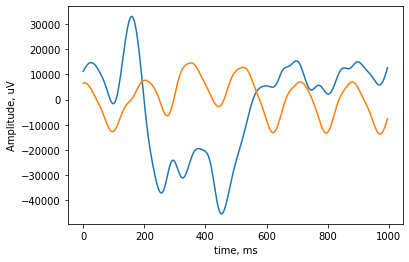

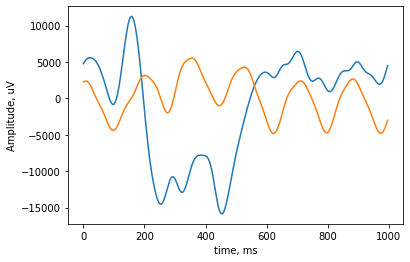

In [34]:
for i in range(10):
    plot_average(data @ w[:10].T, frame, 10, char_box, target_list, Nepochs, i, fs)
# plot_average(data @ w[:, :3], frame, 3, char_box, target_list, Nepochs, 1, fs)
# _ = plot_average(data @ w[:, :3], frame, 3, char_box, target_list, Nepochs, 2, fs)

In [35]:
# bayseian LDA (ridge regression)
class bLDA():

    def __init__(self, alpha=0.1):
        self.alpha = alpha

    def fit(self, X, y):
        X = np.concatenate((X, np.ones((X.shape[0], 1))), axis=1)
        self.w = la.pinv(X.T @ X + self.alpha * np.eye(X.shape[1])) @ X.T @ y

    def decision(self, X):
        X = np.concatenate((X, np.ones((X.shape[0], 1))), axis=1)
        y = (X @ self.w)

        return y
    def decision_function(self, X):
        return self.decision(X)

In [36]:
def extract_features(data):
    num_epochs, num_samples, num_channels = data.shape
    
    # отсчеты, в которых мы будем выдяелять признаки. decim задаем шаг в отсчетах
    decim = 10
    feat_frame = np.arange(int(round(0.1 * fs)), int(round(0.8 * fs)), decim)

    Nsamples = feat_frame.shape[0]

    # признаки. считаем их по эпохам, для каждого стимула по отдельности, в каждой эпозе данный стимул усредняем
    features = np.ndarray((num_epochs * Nstims, data.shape[2] * Nsamples))
    labels = np.ndarray((num_epochs * Nstims,))

    # выдляем признаки
    # для каждой эпохи
    for i in tqdm(range(num_epochs)):
        # для каждого стимула от 1 до 12
        for j in range(1, Nstims + 1):
            # находим отсчеты появляния данных стимулов (15 штук)
            idc = np.where(stims[i, :] == j)[0][:, np.newaxis]
            # берем все повторения данного стимула (15, макс усрденение) и усредняем по ним
            averaged = np.mean(data[i, first_idc[idc] + feat_frame[np.newaxis, :], :], axis=0)

            # векторизуем признаки кол-во каналов* кол-во отсчетов
            features[i * Nstims + j - 1, :] = averaged.flatten()
            # np.sum(averaged**2,axis = 0)/averaged.shape[0]

        # создаем соответствующие метки
        target_stims = np.argwhere(char_box == target_list[i])[0] + 1
        target_stims[1] += int(round(Nstims / 2))
        labels[i * Nstims:(i + 1) * Nstims] = np.isin(stims12, target_stims).astype(int)
    
    return features, labels
# extract_features(data)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 81/81 [00:00<00:00, 1216.86it/s]


((972,), (972,), (972,))

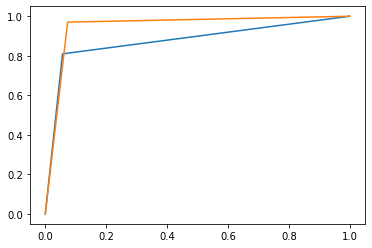

In [37]:
def train(w):
    
    num_channels, num_components = w.shape
    num_epochs, num_samples, num_channels = data.shape
    
    filtered = data @ w
    
    features, labels = extract_features(filtered)

#     plot_average(filtered, frame, num_components, char_box, target_list, num_epochs, 0, fs)

    plt.show()
    LDA = lda(n_components=1)
    SVM = SVC(kernel='rbf')
    blda = bLDA()

    # автоматическое удаление аутлайеров (не принципиально)
    clf = LocalOutlierFactor()
    y_pred = clf.fit_predict(features)

    features = features[y_pred == 1, :]
    labels = labels[y_pred == 1]

    # обучаем 3 модели
    LDA.fit(features, labels)
    SVM.fit(features, labels)
    blda.fit(features, labels)
    
    return LDA, SVM, blda

# just to check
features, labels = extract_features(data @ w[:3].T)
models = train(w[:3].T)

lda_pred = models[0].predict(features)
svm_pred = models[1].predict(features)
blda_pred = models[2].decision(features)

fpr, tpr, thr = roc_curve(lda_pred, labels)
plt.plot(fpr, tpr)
fpr, tpr, thr = roc_curve(svm_pred, labels)
plt.plot(fpr, tpr)
# roc_curve(blda_pred, labels)

lda_pred.shape, svm_pred.shape, blda_pred.shape

In [38]:
def load_test_data(filename='DZ2/2/Subject_A_Test.mat'):
    struct_test = loadmat(filename)
    data_test = struct_test['Signal']
    stim_code = struct_test['StimulusCode']
    return struct_test, data_test, stim_code

In [39]:
def validate(w, model, struct_test=None, data_test=None, stim_code=None):
    
    num_channels, num_components = w.shape
    
    true_seq = 'WQXPLZCOMRKO97YFZDEZ1DPI9NNVGRQDJCUVRMEUOOOJD2UFYPOO6J7LDGYEGOA5VHNEHBTXOO1TDOILUEE5BFAEEXAW_K4R3MRU'

    # загружаем данные для теста
    if struct_test is None:
        struct_test = loadmat('DZ2/2/Subject_A_Test.mat')
        data_test = struct_test['Signal']
        stim_code = struct_test['StimulusCode']

    # обязательно делаем тот же препроцессинг, что и для обучающей выборки!!!
    b, a = sn.butter(4, (0.5, 20), btype='bandpass', fs=fs)
    data_test = sn.filtfilt(b, a, data_test, axis=1)

    filtered_test = data_test @ w

    num_epochs, num_samples, num_channels = filtered_test.shape
    
    # отсчеты, в которых мы будем выдяелять признаки. decim задаем шаг в отсчетах
    decim = 10
    feat_frame = np.arange(int(round(0.1 * fs)), int(round(0.8 * fs)), decim)
    Nsamples = feat_frame.shape[0]

    stims_test = stim_code[:, first_idc].astype('int')
    
    N_average = np.arange(1, 16, dtype='int')  # np.arange(1,16,dtype = 'int')
    accuracy = np.ndarray(N_average.shape[0])
    
    for n_window in range(N_average.shape[0]):
        # строка, в которую будем вписывать декодированные символы, счетчик попаданий
        decoded_str = ''
        count_hits = 0

        # выделяем признаки из тестовых данных. Все так же, как и для обучающих, тольок теперь для усреднений берем
        # тольок N_average первых полявленйи данного стимула в эпохе
        features_test = np.ndarray((num_epochs * Nstims, num_components * Nsamples))
        for i in range(num_epochs):
            for j in range(1, Nstims + 1):
                idc = np.where(stims_test[i, :] == j)[0][:, np.newaxis]

                averaged = np.mean(filtered_test[i, first_idc[idc[:N_average[n_window], ]] + 
                                                 feat_frame[np.newaxis, :], :], axis=0)
                features_test[i * Nstims + j - 1, :] = averaged.flatten()
                # np.sum(averaged**2,axis = 0)/averaged.shape[0]

            # считаем вероятности схожести данного стимула с p300
            probabilities = model.decision_function(features_test[i*Nstims:(i+1)*Nstims,:])

            # разбиваем вероятности для стимулов от 1 до 6 (столбцы) и от 7 до 12 (строки)
            probabilities = probabilities.reshape((2, int(round(probabilities.shape[0] / 2))))
            # выбираем среди строк и столбцов наиболее похожие на p300 стимулы, декодируем символ
            decoded_str += char_box[np.argmax(probabilities[0, :]), np.argmax(probabilities[1, :])]

            if decoded_str[i] == true_seq[i]:
                count_hits += 1

        accuracy[n_window] = count_hits / len(true_seq)
    if N_average.shape[0] != 1:
        # information tranfer rate
        SR = 60 / (2.5 + 0.175 * 12 * N_average)
        # 60 seconds, 2.5 seconds between charecter epoch, 0.175 s for one stimulus
        # flashing (with blank period 0.075 s, according to description), 12 stimulus, number of repetitions

        B = np.log2(36) + accuracy * np.log2(accuracy) + (1 - accuracy) * np.log2((1 - accuracy) / (36 - 1))
        # 36 charecters

#         ITR = B * SR
#         fig, ax = plt.subplots(1, 2, figsize=(20, 8))
#         ax[0].plot(N_average, ITR, linestyle=':')
#         ax[0].scatter(N_average, ITR)
#         ax[0].set_xlabel('Num of averagings')
#         ax[0].set_ylabel('information transfer rate, bits/min')
#         ax[0].set_ylabel('ITR')

#         ax[1].plot(N_average, accuracy, linestyle=':')
#         ax[1].scatter(N_average, accuracy)
#         ax[1].set_xlabel('Num of averagings')
#         ax[1].set_ylabel('accuracy')
#         ax[1].set_title('accuracy')

    return accuracy

# validate(w[:3].T, models)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 81/81 [00:00<00:00, 1591.55it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 81/81 [00:00<00:00, 1366.90it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 81/81 [00:00<00:00, 1380.15it/s]


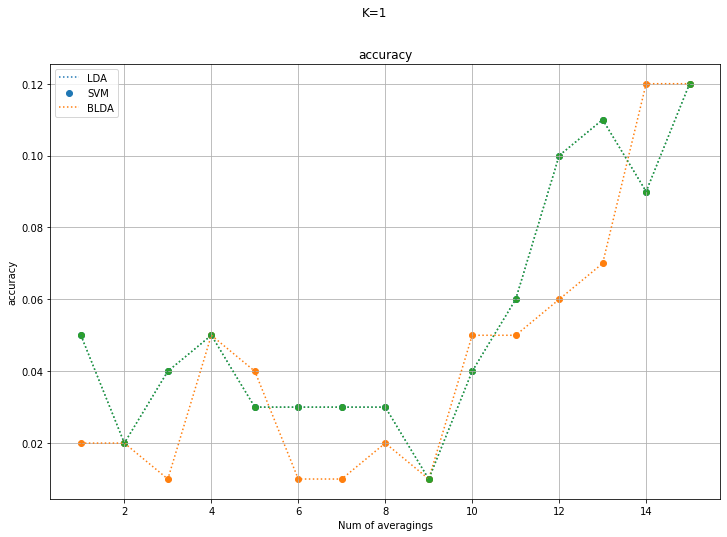

100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 81/81 [00:00<00:00, 959.78it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 81/81 [00:00<00:00, 673.71it/s]


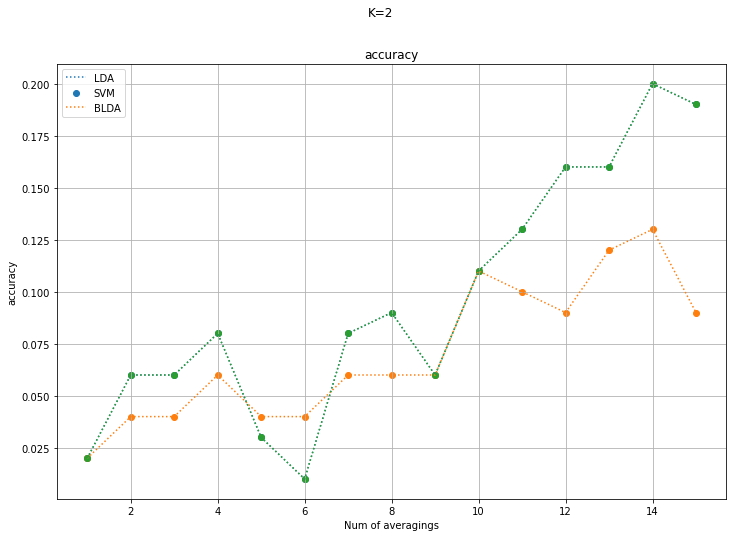

100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 81/81 [00:00<00:00, 1294.13it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 81/81 [00:00<00:00, 1021.61it/s]


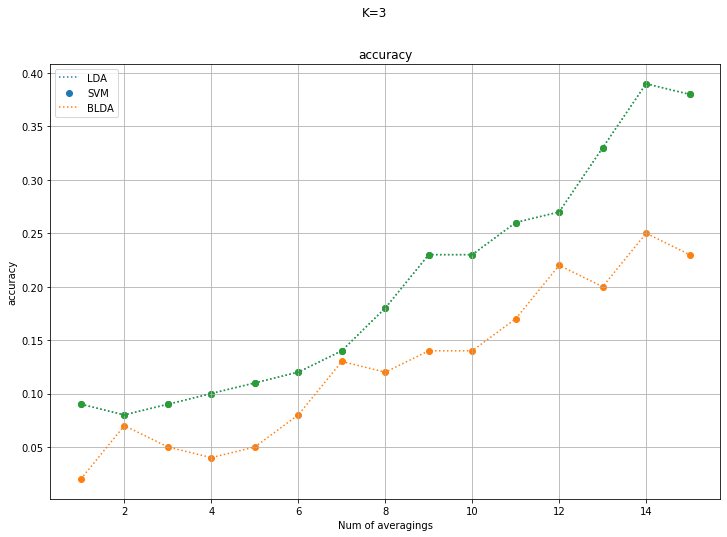

100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 81/81 [00:00<00:00, 1274.01it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 81/81 [00:00<00:00, 1281.06it/s]


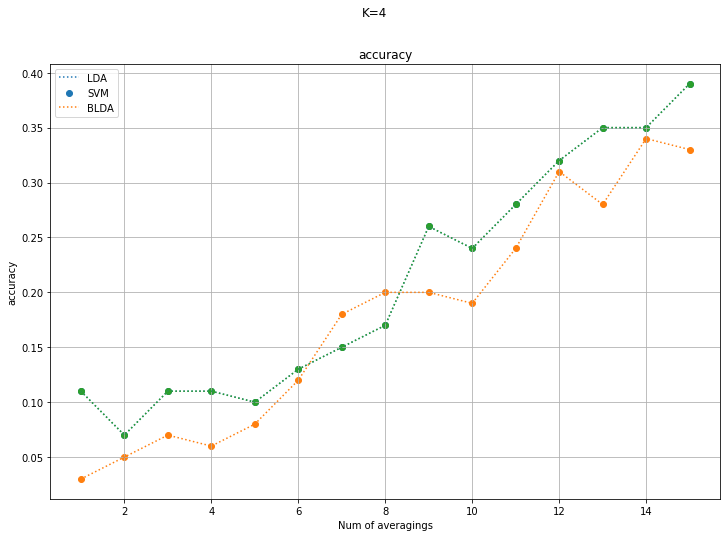

100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 81/81 [00:00<00:00, 1236.46it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 81/81 [00:00<00:00, 871.01it/s]


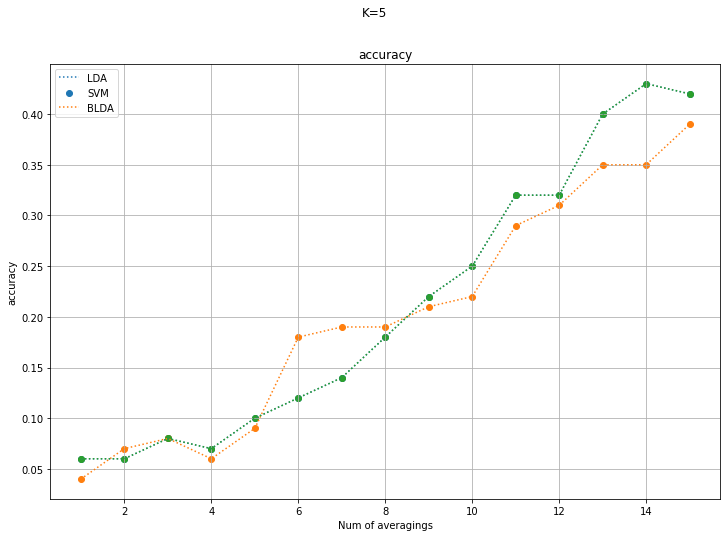

100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 81/81 [00:00<00:00, 1210.05it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 81/81 [00:00<00:00, 1180.27it/s]


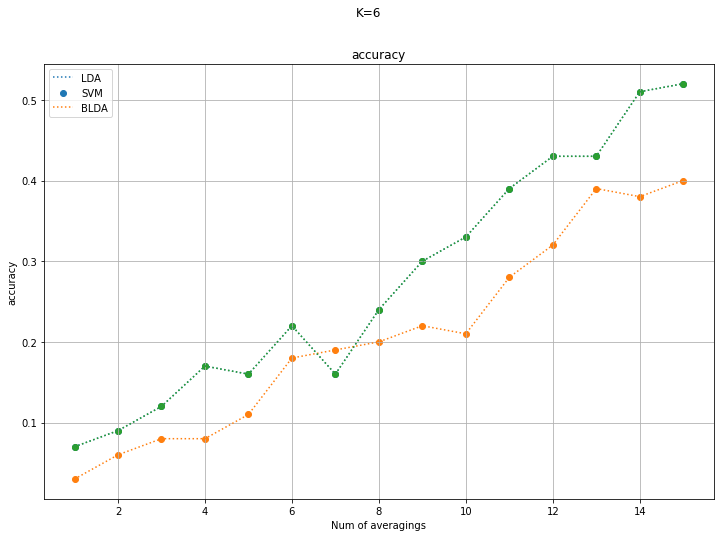

100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 81/81 [00:00<00:00, 1135.91it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 81/81 [00:00<00:00, 1172.96it/s]


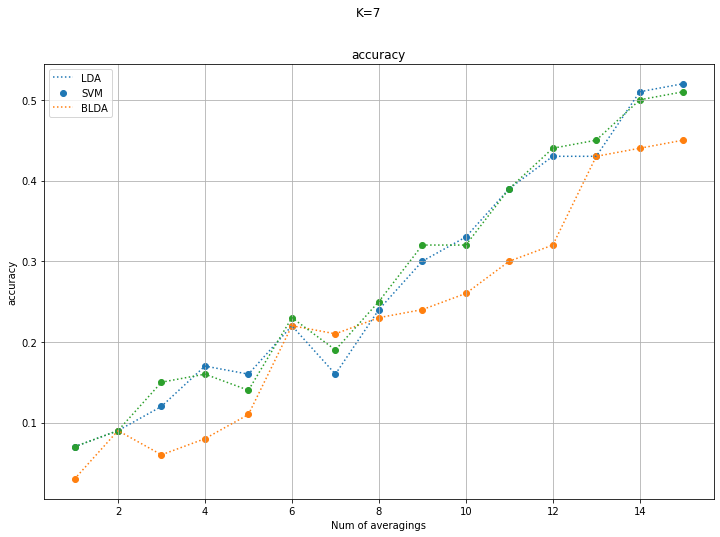

100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 81/81 [00:00<00:00, 1171.03it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 81/81 [00:00<00:00, 1180.41it/s]


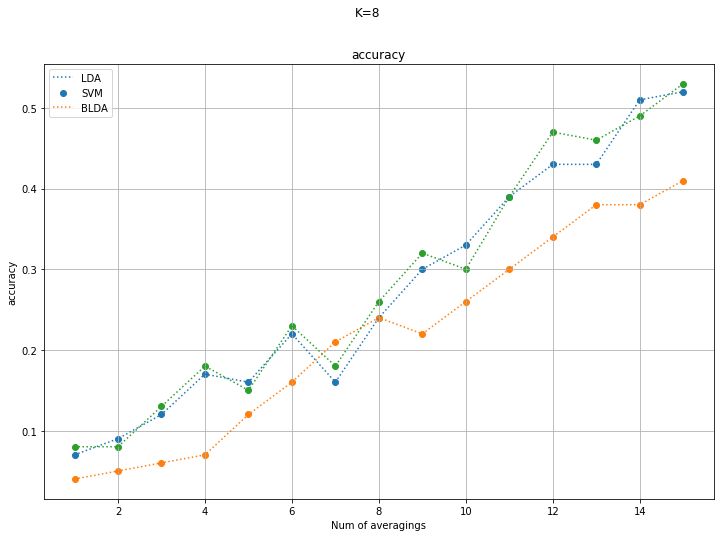

100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 81/81 [00:00<00:00, 970.12it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 81/81 [00:00<00:00, 1609.41it/s]


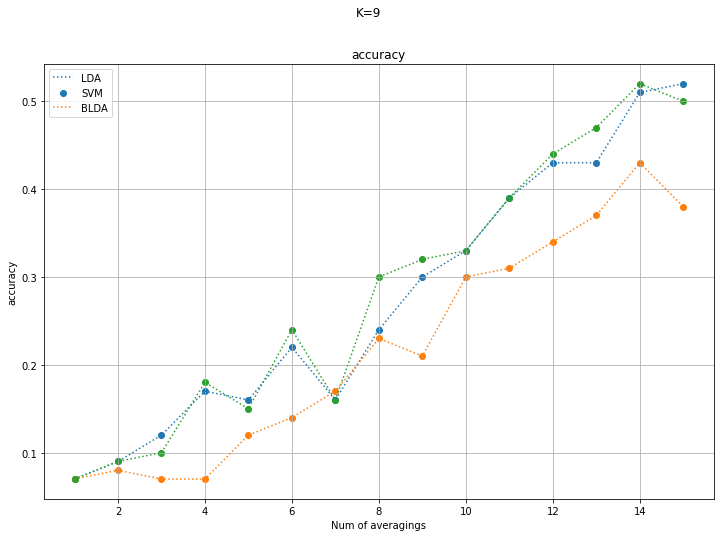

100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 81/81 [00:00<00:00, 1109.89it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 81/81 [00:00<00:00, 1112.57it/s]


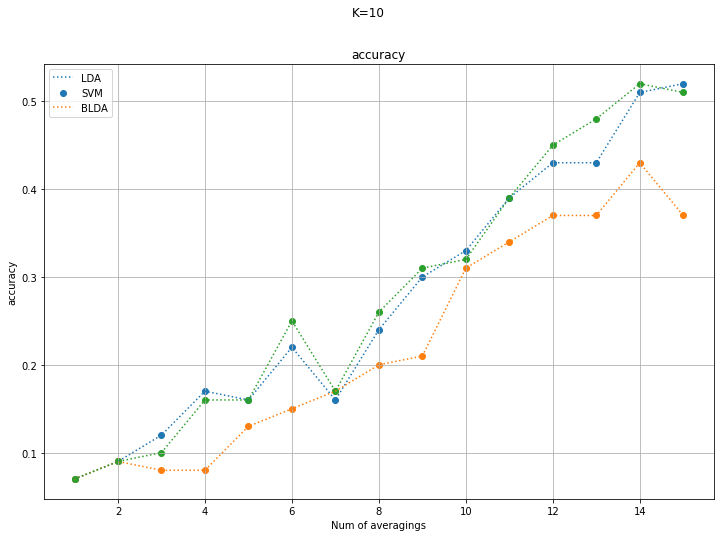

100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 81/81 [00:00<00:00, 1140.22it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 81/81 [00:00<00:00, 1147.19it/s]


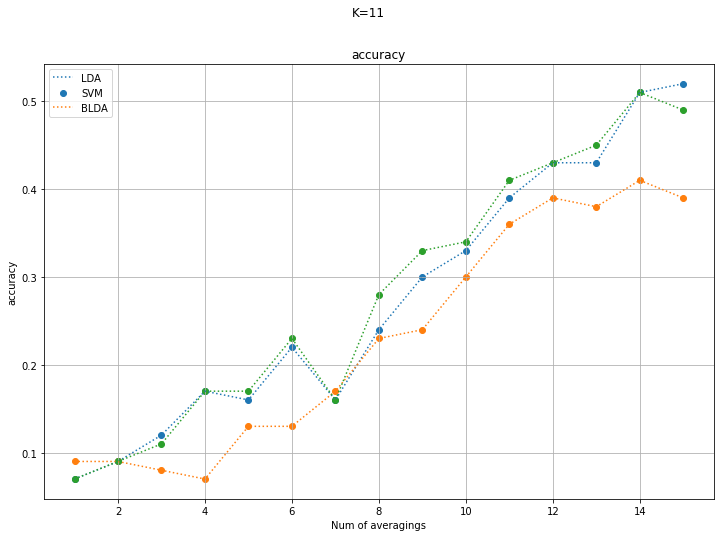

100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 81/81 [00:00<00:00, 1081.33it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 81/81 [00:00<00:00, 961.09it/s]


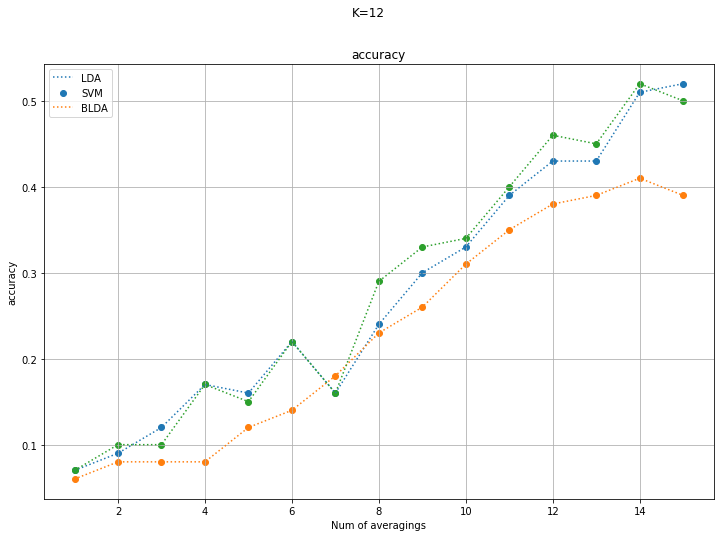

100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 81/81 [00:00<00:00, 1110.44it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 81/81 [00:00<00:00, 998.44it/s]


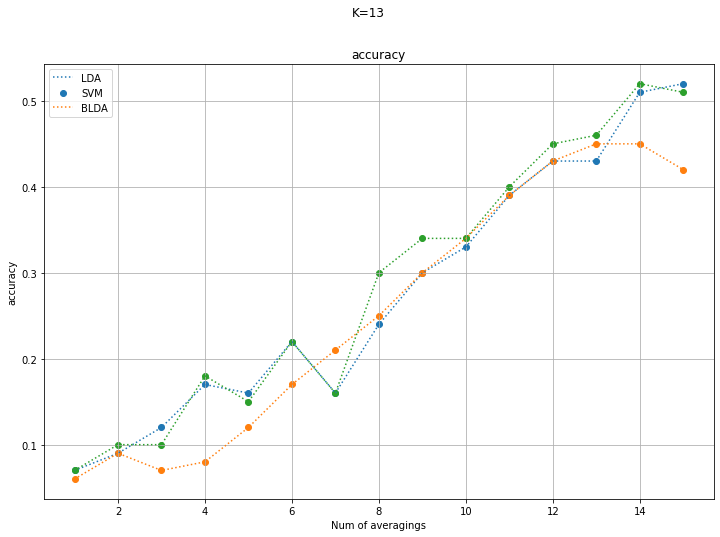

100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 81/81 [00:00<00:00, 1114.18it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 81/81 [00:00<00:00, 1035.53it/s]


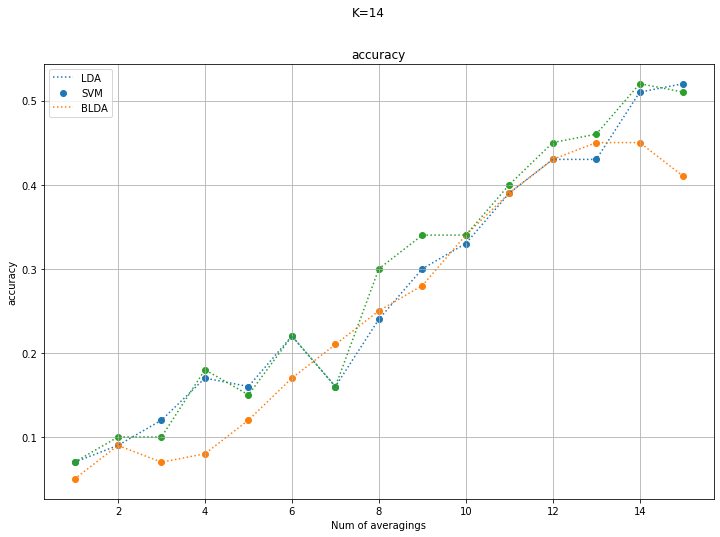

100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 81/81 [00:00<00:00, 1084.79it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 81/81 [00:00<00:00, 922.28it/s]


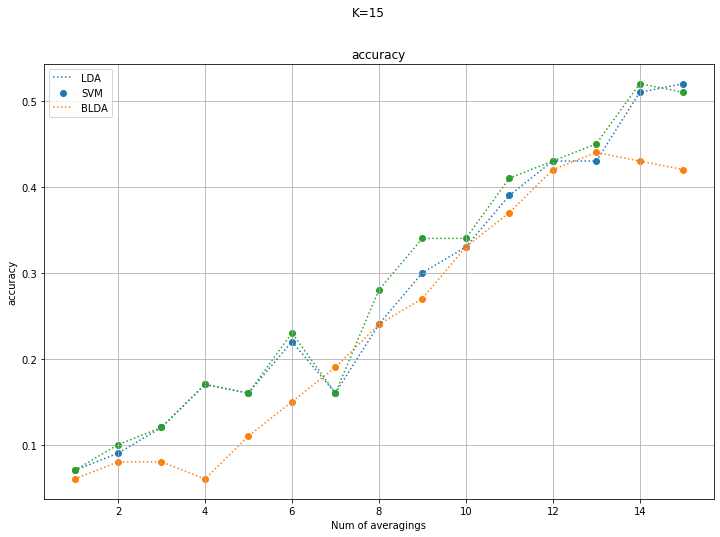

100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 81/81 [00:00<00:00, 1037.83it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 81/81 [00:00<00:00, 925.15it/s]


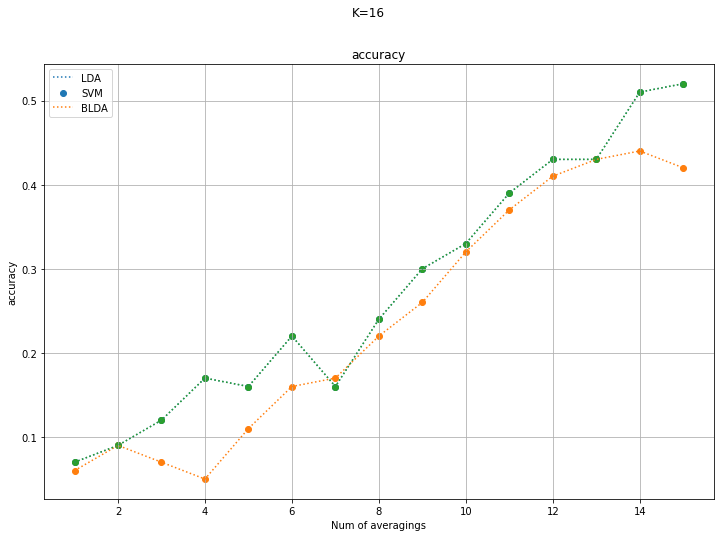

100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 81/81 [00:00<00:00, 1041.01it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 81/81 [00:00<00:00, 1019.46it/s]


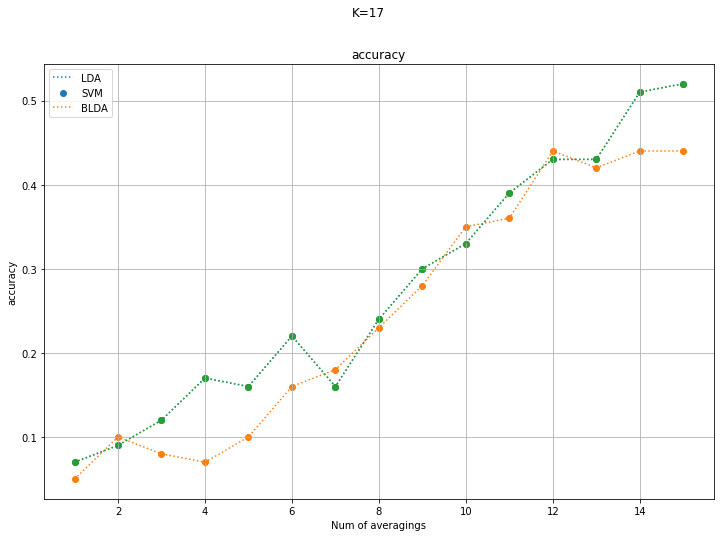

100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 81/81 [00:00<00:00, 1027.64it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 81/81 [00:00<00:00, 1026.46it/s]


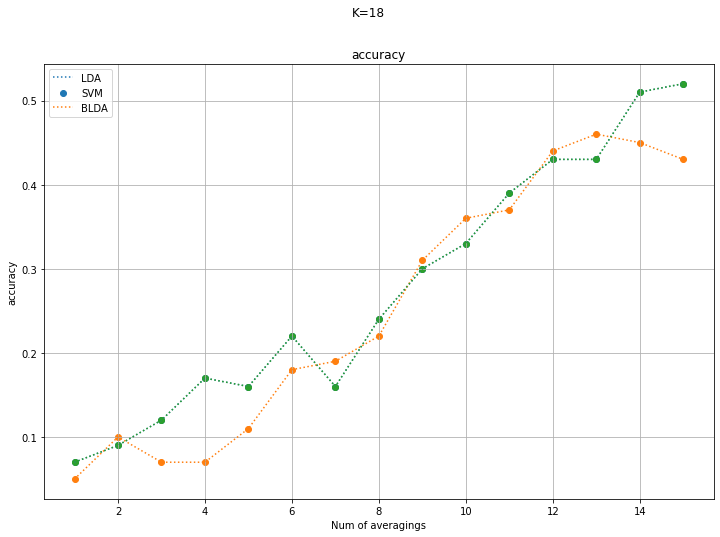

100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 81/81 [00:00<00:00, 1038.53it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 81/81 [00:00<00:00, 970.79it/s]


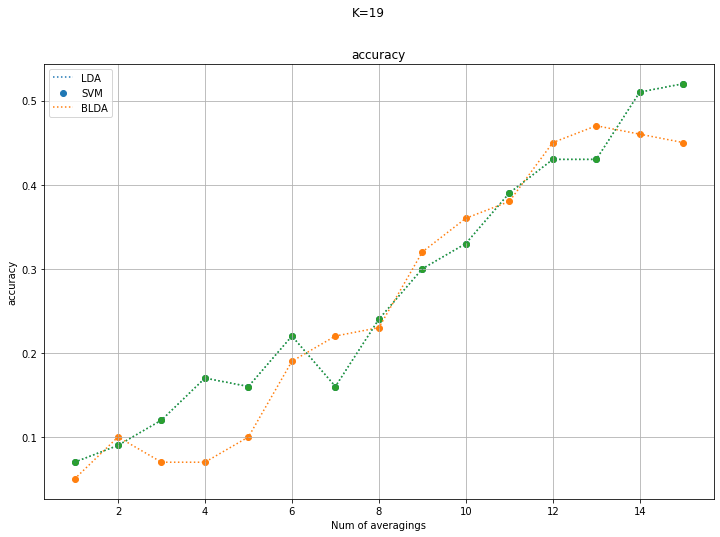

100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 81/81 [00:00<00:00, 984.63it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 81/81 [00:00<00:00, 895.24it/s]


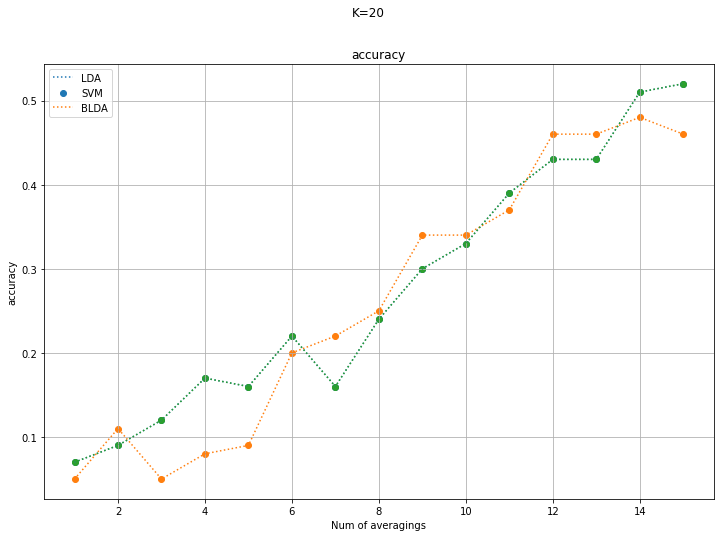

100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 81/81 [00:00<00:00, 1001.15it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 81/81 [00:00<00:00, 1003.30it/s]


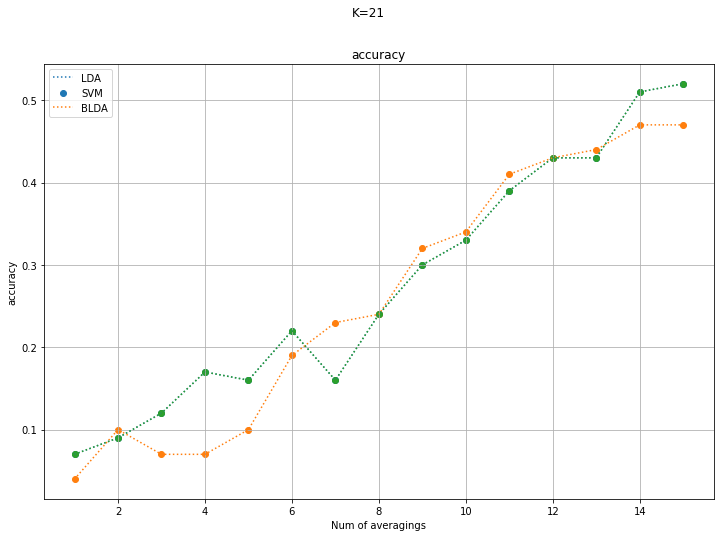

100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 81/81 [00:00<00:00, 984.18it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 81/81 [00:00<00:00, 971.73it/s]


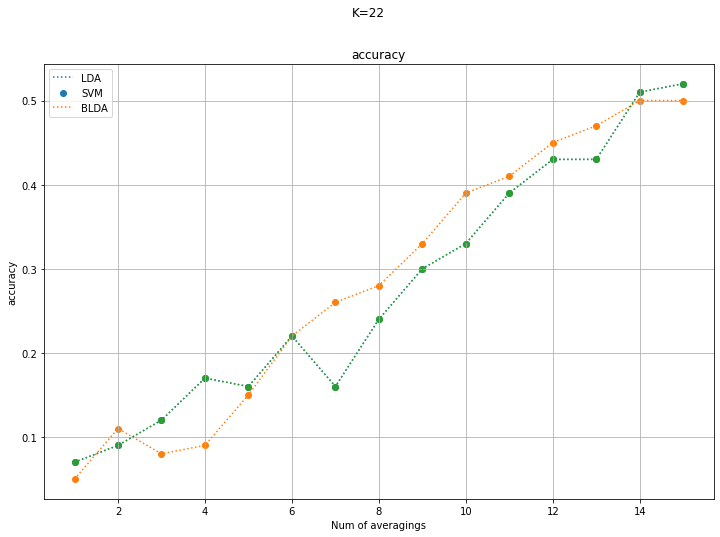

100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 81/81 [00:00<00:00, 970.39it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 81/81 [00:00<00:00, 954.71it/s]


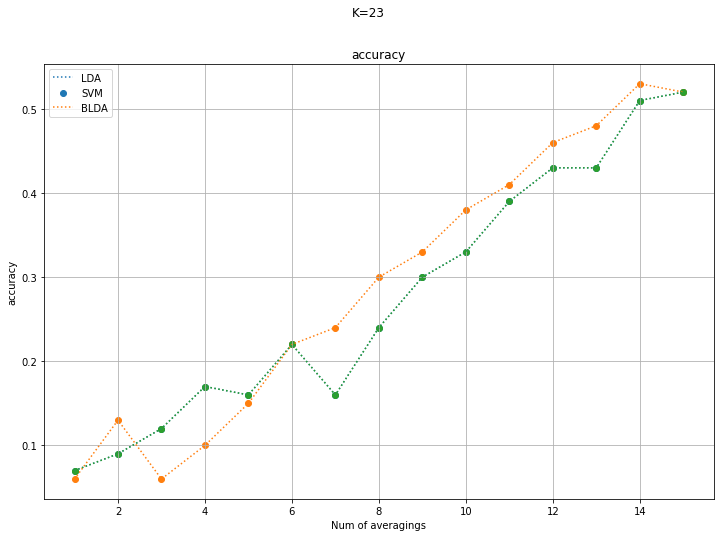

100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 81/81 [00:00<00:00, 970.24it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 81/81 [00:00<00:00, 972.14it/s]


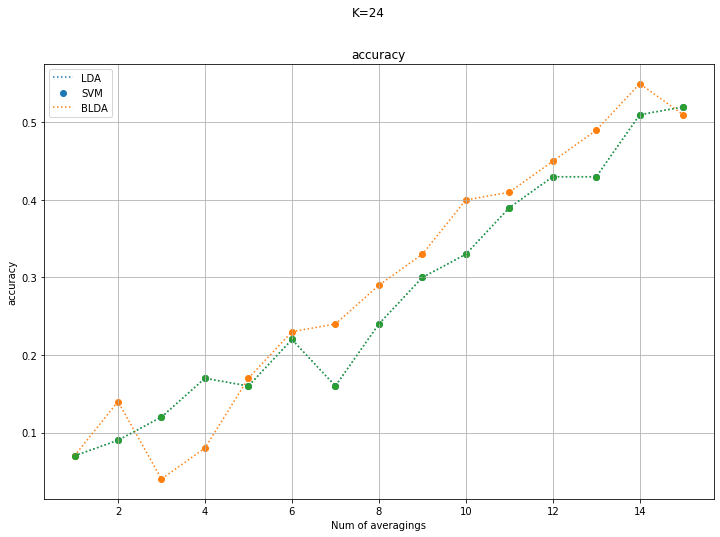

100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 81/81 [00:00<00:00, 971.15it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 81/81 [00:00<00:00, 967.24it/s]


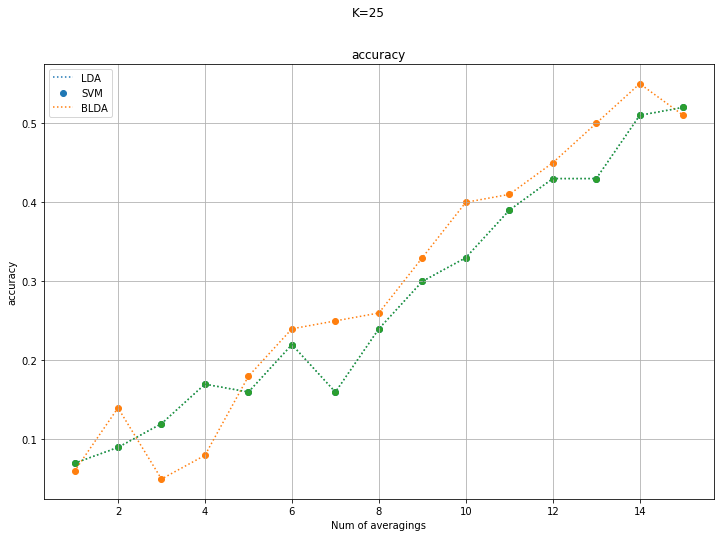

100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 81/81 [00:00<00:00, 1017.48it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 81/81 [00:00<00:00, 970.68it/s]


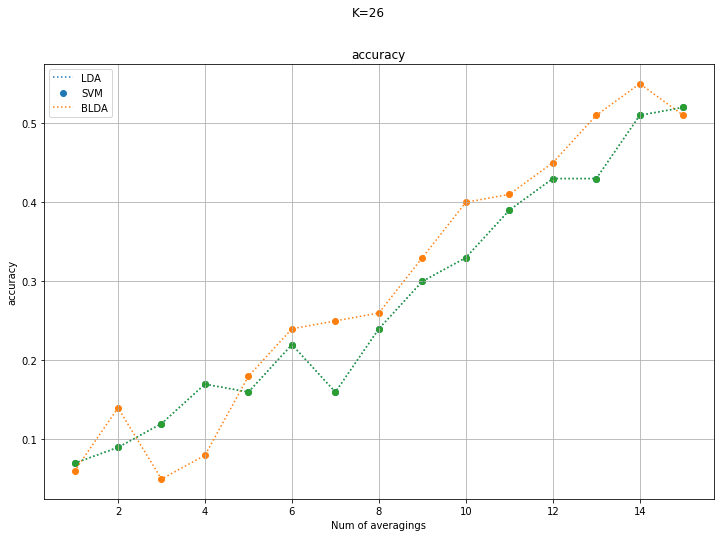

100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 81/81 [00:00<00:00, 972.87it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 81/81 [00:00<00:00, 977.64it/s]


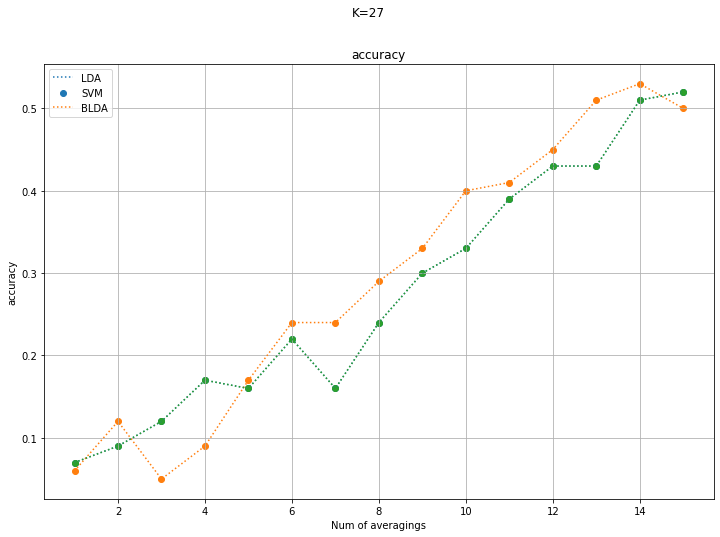

100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 81/81 [00:00<00:00, 968.05it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 81/81 [00:00<00:00, 966.75it/s]


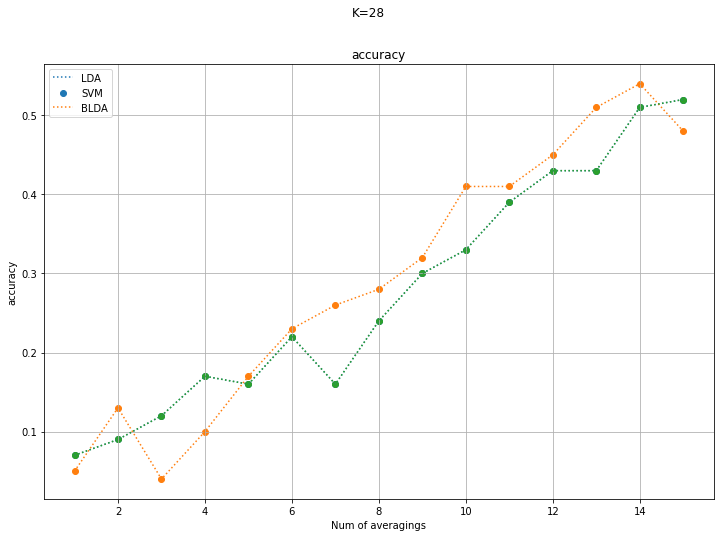

100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 81/81 [00:00<00:00, 968.45it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 81/81 [00:00<00:00, 967.60it/s]


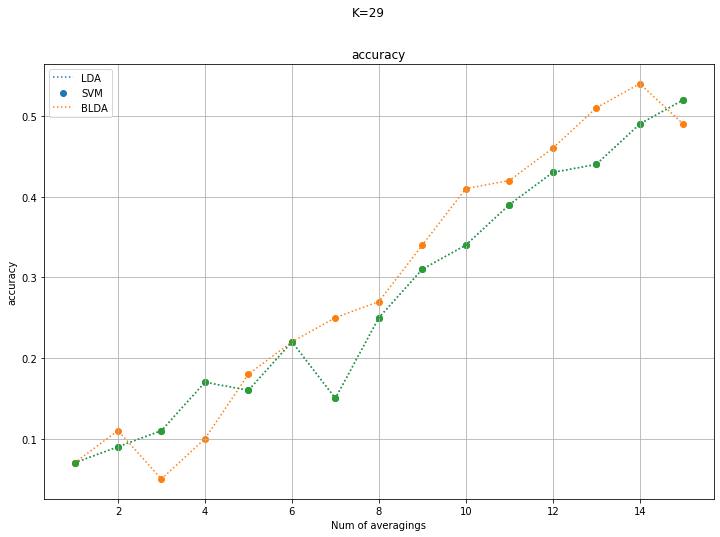

100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 81/81 [00:00<00:00, 773.18it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 81/81 [00:00<00:00, 916.43it/s]


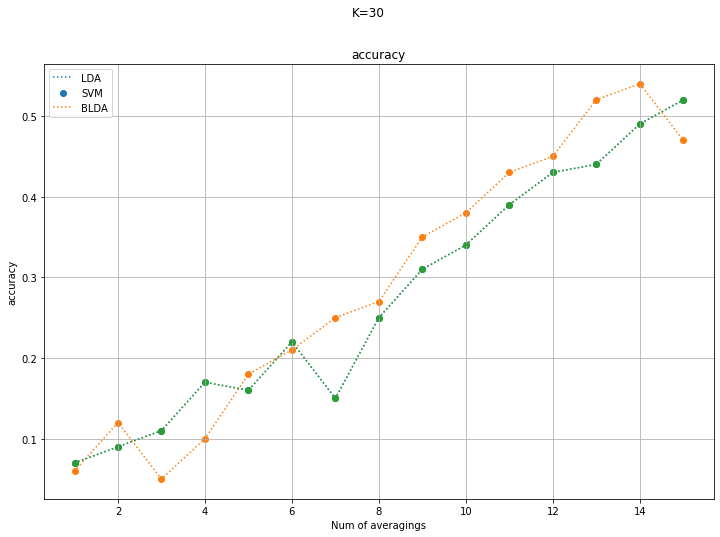

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [06:37<00:00, 12.82s/it]

{1: 0.12, 2: 0.2, 3: 0.39, 4: 0.39, 5: 0.43, 6: 0.52, 7: 0.52, 8: 0.53, 9: 0.52, 10: 0.52, 11: 0.52, 12: 0.52, 13: 0.52, 14: 0.52, 15: 0.52, 16: 0.52, 17: 0.52, 18: 0.52, 19: 0.52, 20: 0.52, 21: 0.52, 22: 0.52, 23: 0.53, 24: 0.55, 25: 0.55, 26: 0.55, 27: 0.53, 28: 0.54, 29: 0.54, 30: 0.54, 31: 0.53}


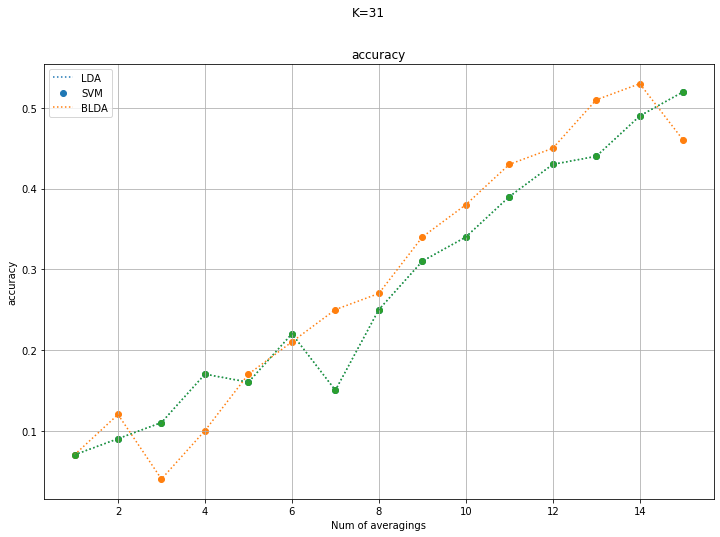

In [40]:
%matplotlib inline

acc_stat = {}

model_names = ['LDA', 'SVM', 'BLDA']

struct_test, data_test, stim_code_test = load_test_data()

for k in tqdm(range(1, len(lam) // 2)):
#     plt.close('all')
    w_ = w[:k].T
    features, labels = extract_features(data @ w_)
    models = train(w_)
    fig, ax = plt.subplots(1, 1, figsize=(12, 8))
    fig.suptitle(f'K={k}')
    acc = []
    for model, model_name in zip(models, model_names):
        accuracy = validate(w_, model, struct_test, data_test, stim_code_test)
        ax.plot(range(1, len(accuracy) + 1), accuracy, linestyle=':')
        ax.scatter(range(1, len(accuracy) + 1), accuracy)
        ax.set_xlabel('Num of averagings')
        ax.set_ylabel('accuracy')
        ax.set_title('accuracy')
        ax.grid()
        ax.legend(model_names)
        
        acc.append(np.max(accuracy))
        
    acc_stat[(k)] = np.max(acc)
print(acc_stat)
#     print(k)
#     print(accuracy)

0.55


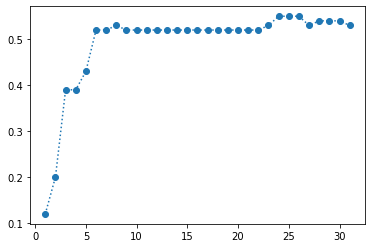

In [45]:
acc_stat, np.max(list(acc_stat.values()))
plt.plot(acc_stat.keys(), acc_stat.values(), linestyle=':')
plt.scatter(acc_stat.keys(), acc_stat.values())
print(np.max(list(acc_stat.values())))